In [7]:
from causallib.datasets import load_nhefs
from causallib.estimation import IPW, PropensityMatching, StratifiedStandardization
from causallib.evaluation import evaluate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

In [8]:
from causallib.datasets import load_nhefs

# ============================================================
# NHEFS データセットの読み込み
# ============================================================
# load_nhefs() は、causallib に同梱されている
#   NHEFS (National Health and Nutrition Examination Follow-up Study)
# の禁煙 × 体重変化データを読み込むユーティリティ関数。
#
# このデータは Hernán & Robins『Causal Inference: What If』の
# 典型例としても使われている、因果推論の「教科書的」データセットで、
#
#   - 対象：1970–80年代のコホート
#   - 介入（treatment）: 喫煙をやめたか否か（quit smoking）
#   - アウトカム（outcome）: 1971–1982 年の体重変化（wt82_71）
#   - 共変量（covariates）: 年齢・性別・喫煙歴・健康状態など多数
#
# といった構造を持つ「観察研究デザイン」のデータである。
#
# causallib の load_nhefs() は、単なる DataFrame ではなく
# sklearn の Bunch に似たオブジェクトを返し、
#
#   data.X : 共変量（交絡因子を含む特徴量）の DataFrame
#   data.a : 介入変数（禁煙したかどうか, 0/1）の Series
#   data.y : 観測アウトカム（体重差 wt82_71）の Series
#   data.po: 可能性アウトカム（ポテンシャルアウトカム）への擬似的な真値
#   data.descriptors : 各変数の意味に関するメタデータ
#
# といった属性にアクセスできる。
#
# 理論的な位置づけ：
# - この一行で「IPW（逆確率重み付け）」「標準化」「ダブルロバスト推定」など、
#   さまざまな因果推定アルゴリズムを試せる実験用データが手に入る。
# - 特に、data.X をバックドア調整集合として扱い、
#   data.a を処置変数、data.y をアウトカムとして ATE/ATT を推定する、
#   というポテンシャルアウトカム・フレームワークの典型的な流れを
#   そのままコードで体験できる。
data = load_nhefs()

In [9]:
# ============================================================
# 傾向スコア（propensity score）モデルの定義
# ============================================================
# 傾向スコア e(X) は、
#
#   e(X) = P(A = 1 | X)
#
# のことを指し、「共変量 X を持つ個体が、介入 A=1 を受ける条件付き確率」を表す。
# ポテンシャルアウトカム・フレームワークでは、
#
#   - A: 処置（例：禁煙したかどうか）
#   - Y: アウトカム（例：体重変化）
#   - X: 共変量（交絡因子を含む要因）
#
# としたとき、交絡の制御を行うために e(X) を推定し、
# その値を用いてマッチング・IPW・層化などを行うことで、
# 「A と X が独立になるような擬似ランダム化」を実現しようとする。
#
# ここでは、その e(X) を **ロジスティック回帰モデル**で推定している。
# ============================================================

# 傾向スコアを算出するためのロジスティック回帰モデルを定義
learner = LogisticRegression(
    # solver は最適化アルゴリズムの種類を指定する引数。
    #
    # - "liblinear" は L2 正則化つきロジスティック回帰の古典的な解法の一つで、
    #   特にサンプル数や特徴量数がそこまで巨大でない場合に安定して動作しやすい。
    # - 小〜中規模データセットでの二値分類（今回のような A∈{0,1}）には十分であり、
    #   収束性や数値安定性の点からも扱いやすい設定。
    solver="liblinear",
    # class_weight="balanced" は、クラス不均衡（例：禁煙者が少ない／多い）の補正のための設定。
    #
    # - 通常、ロジスティック回帰は「サンプル数の多いクラス」に引きずられやすい。
    #   例えば A=0 が 90%、A=1 が 10% のような場合、
    #   何もしないと「ほとんど A=0 と予測してしまう」モデルでも
    #   損失がそれなりに小さくなってしまう。
    #
    # - class_weight="balanced" とすることで、
    #   各クラスの重みを 1 / (サンプル数 × クラス頻度) に比例させ、
    #   事実上「少数クラスを重く扱う」ようにする。
    #
    # 傾向スコア推定の観点では、
    # - P(A=1 | X), P(A=0 | X) のどちらも適切に学習されないと
    #   IPW やマッチング時に極端な重みが出やすくなる。
    # - そのため、クラス不均衡があるケースでは class_weight を調整して
    #   推定の安定性を高めるのは理にかなっている。
    class_weight="balanced",
)

# ============================================================
# 傾向スコアの算出とマッチング（Propensity Matching）
# ============================================================
# PropensityMatching は causallib が提供する「傾向スコアマッチング」のクラス。
#
# 理論的なアイデア：
# - e(X) = P(A=1 | X) を推定したあと、
#   「処置群 A=1 の個体」と「対照群 A=0 の個体」を
#   傾向スコア e(X) が近いペア同士でマッチングする。
#
# - うまくマッチングできれば、マッチされたサンプル集合においては
#   共変量 X と処置 A がほぼ独立になり、
#   「ランダム化実験に近い状況」が得られると期待される。
#
# - その上で、マッチされたペア間のアウトカム Y の差を平均することで、
#   A の Y に対する因果効果（例えば ATT: 処置群平均処置効果）を推定する。
#
# ここでは、先ほど定義したロジスティック回帰 learner を
# 「傾向スコア推定器」として PropensityMatching に渡している。
pm = PropensityMatching(learner=learner)

# ------------------------------------------------------------
# モデルの学習（fit）
# ------------------------------------------------------------
# pm.fit(X, a, y) の引数の意味：
#
# - data.X : 共変量（交絡因子を含む特徴量）
#   → 傾向スコア e(X) の説明変数になる。
#
# - data.a : 処置変数（例：禁煙したかどうか, 0/1）
#   → 傾向スコアの目的変数（ロジスティック回帰のラベル）。
#
# - data.y : アウトカム（例：体重変化）
#   → マッチング後に因果効果を評価するために用いられる。
#
# fit の内部で行われること（概念的な流れ）：
#   1. learner（ロジスティック回帰）で e_hat(X) ≈ P(A=1 | X) を推定
#   2. e_hat(X) を用いて A=1 と A=0 の個体をマッチング
#   3. マッチング結果（インデックスのペアや重み）を内部に保持
#
# この段階ではまだ「因果効果（ATE/ATT）」自体は計算していないが、
# 後続で pm.estimate_population_outcome(...), pm.estimate_effect(...),
# あるいは causallib の標準 API を用いることで、
# 実際の効果推定に進むことができる。
pm.fit(data.X, data.a, data.y)

PropensityMatching(caliper=None, covariance_conditioner=EmpiricalCovariance(), estimate_observed_outcome=False, knn_backend=sklearn, matching_mode=both, metric=mahalanobis, n_neighbors=1, propensity_transform=PropensityTransformer(learner=LogisticRegression(class_weight='balanced',
                                                 solver='liblinear')), with_replacement=True,
                   learner=LogisticRegression(class_weight='balanced', solver='liblinear'))

In [10]:
# ============================================================
# ATE（Average Treatment Effect：平均処置効果）の推定
# ============================================================
# ここまでで pm.fit(data.X, data.a, data.y) によって、
# - 傾向スコア e_hat(X) の推定
# - それに基づくマッチング
# が内部的に完了している。
#
# このコードブロックでは、
#   1. 処置群・対照群それぞれの「平均アウトカム」を推定
#   2. その差として ATE を計算
#   3. 人間に読みやすい形で出力
# を行っている。
# ============================================================

# ------------------------------------------------------------
# 1. 処置群・対照群の「反事実を含む」平均アウトカムの推定
# ------------------------------------------------------------
# estimate_population_outcome(X, a) の役割：
#
# - 引数：
#   - data.X : 共変量（交絡因子を含む特徴量）
#   - data.a : 実際の処置割り当て（A=0/1）
#
# - 返り値：
#   - outcomes[0] : 「全員が A=0（非処置）だったと仮定した場合の平均アウトカム」の推定値
#   - outcomes[1] : 「全員が A=1（処置）だったと仮定した場合の平均アウトカム」の推定値
#
# 理論的には、これはポテンシャルアウトカム
#
#   μ0 = E[Y(0)]
#   μ1 = E[Y(1)]
#
# を推定していると解釈できる。
# 傾向スコアマッチングでは、マッチングされたペア（擬似ランダム化サンプル）の上で
# アウトカムを集計することで、これらの期待値を近似する。
outcomes = pm.estimate_population_outcome(data.X, data.a)

# ------------------------------------------------------------
# 2. ATE（μ1 - μ0）の推定
# ------------------------------------------------------------
# estimate_effect(mu1, mu0) は、与えられた2つの「平均アウトカム」から
# さまざまな効果指標を計算するヘルパー。
#
# - 引数：
#   - outcomes[1] : μ1 の推定値（全員が処置された世界の平均 Y）
#   - outcomes[0] : μ0 の推定値（全員が非処置の世界の平均 Y）
#
# - 返り値：
#   - effect["diff"] : μ1 - μ0 （差分：Difference in Means）
#     → これが ATE（Average Treatment Effect）に対応する。
#
# ポテンシャルアウトカム理論では、
#   ATE = E[Y(1) - Y(0)] = E[Y(1)] - E[Y(0)] = μ1 - μ0
# という関係があるため、μ1 と μ0 を別々に推定して差を取ることで ATE を推定する。
effect = pm.estimate_effect(outcomes[1], outcomes[0])

# ------------------------------------------------------------
# 3. 推定結果の出力
# ------------------------------------------------------------
# 概念的な意味：
# - "Average outcome of Untreated" :
#     μ0 = E[Y(0)] を推定したもの。
#     「全員が未介入（禁煙しなかった）世界での平均体重変化」に対応。
#
# - "Average outcome of Treated" :
#     μ1 = E[Y(1)] を推定したもの。
#     「全員が介入（禁煙した）世界での平均体重変化」に対応。
#
# - "Average Treatment Effect" :
#     μ1 - μ0 = ATE。
#     「もし全員を禁煙させた場合と、誰も禁煙させなかった場合の
#       体重変化の平均の差」を表す因果効果。
#
# この3つを並べて出力することで、
# - 絶対水準（μ0, μ1）がどのくらいか
# - 差分（ATE）がどの程度の大きさか
# が直感的に理解しやすくなる。
print(f"Average outcome of Untreated: {outcomes[0]:.3f}")
print(f"Average outcome of Treated: {outcomes[1]:.3f}")
print(f'Average Treatment Effect: {effect["diff"]:.3f}')

Average outcome of Untreated: 1.737
Average outcome of Treated: 5.434
Average Treatment Effect: 3.698


In [12]:
# ------------------------------------------------------------
# 傾向スコアを算出するモデルの定義
# ------------------------------------------------------------
# LogisticRegression は「共変量 X から処置 A（0/1）を予測する」二値分類モデル。
# このとき予測確率
#   P(A=1 | X) = e(X)
# が「傾向スコア（propensity score）」となる。
#
# ・solver="liblinear"
#   小〜中規模データ向けのソルバで、L1/L2 正則化に対応。
#   NHEFS のようなサイズ感では計算が安定しやすい。
#
# ・class_weight="balanced"
#   処置群と対照群のサンプル数が不均衡なとき、
#   各クラスの重みを 1 /（クラス出現頻度）で自動調整し、
#   学習時のバランスを取るオプション。
#   傾向スコア e(X) を安定して推定するための工夫と言える。
learner = LogisticRegression(solver="liblinear", class_weight="balanced")

# ------------------------------------------------------------
# 傾向スコアを算出し、IPW（逆確率重み付け）を実施
# ------------------------------------------------------------
# IPW（Inverse Probability Weighting）のアイデア：
#   ・観測データでは A は交絡された形で割り付けられているが、
#   ・傾向スコア e(X) = P(A=1|X) を用いて
#       - 処置群の重み:   w_i = 1 / e(X_i)
#       - 対照群の重み:   w_i = 1 / (1 - e(X_i))
#     という「逆確率重み」を掛けると、
#   ・理想的には「X によらず A がほぼランダムに割り付けられた」
#     擬似的な実験データになる（交絡を補正できる）という理論。
#
# causallib の IPW クラスは、
#   1. learner で傾向スコアを学習
#   2. その結果から内部的に重み w_i を計算
# までを一括して行ってくれる。
ipw = IPW(learner=learner)

# fit では、
#   - data.X : 共変量（年齢、性別、喫煙歴など）
#   - data.a : 処置（例：禁煙したかどうか A=1/0）
# を使って、傾向スコアモデルを学習し、各サンプルの重み w_i を算出して内部に保存する。
ipw.fit(data.X, data.a)

# ------------------------------------------------------------
# ATE（Average Treatment Effect）の計算
# ------------------------------------------------------------
# estimate_population_outcome:
#   「全員が A=0 の世界」「全員が A=1 の世界」における平均アウトカム
#   E[Y(0)] と E[Y(1)] を、IPW 重み付きの標本平均として推定する関数。
#
#   ここで data.y は実際に観測されたアウトカム（例：体重変化）であり、
#   IPW によって「処置割り付けのバイアスを補正した上での平均」を再構成する。
#
# 戻り値 outcomes は通常、
#   outcomes[0] ≈ E[Y(0)]（全員 untreated の世界）
#   outcomes[1] ≈ E[Y(1)]（全員 treated   の世界）
# を表す。
outcomes = ipw.estimate_population_outcome(data.X, data.a, data.y)

# estimate_effect:
#   上で推定した E[Y(0)], E[Y(1)] から因果効果を計算する。
#   もっとも基本的なスカラーは平均処置効果（ATE）であり、
#
#     ATE = E[Y(1)] - E[Y(0)]
#
#   と定義される。
#
#   causallib の実装では、差分を "diff" というキーで返す辞書になっている。
effect = ipw.estimate_effect(outcomes[1], outcomes[0])

# ------------------------------------------------------------
# 結果の出力（因果効果の解釈）
# ------------------------------------------------------------
# ・Average outcome of Untreated:
#     IPW により「全員が介入を受けなかった世界」を再構成したときの
#     平均アウトカム E[Y(0)] の推定値。
#
# ・Average outcome of treated:
#     IPW により「全員が介入（禁煙など）を受けた世界」を再構成したときの
#     平均アウトカム E[Y(1)] の推定値。
#
# ・Average Treatment Effect:
#     ATE = E[Y(1)] - E[Y(0)]。
#     正の値であれば「介入によりアウトカムが平均的に増える」、
#     負の値であれば「介入によりアウトカムが平均的に減る」効果を意味する。
print(f"Average outcome of Untreated: {outcomes[0]:.3f}")
print(f"Average outcome of treated: {outcomes[1]:.3f}")
print(f'Average Treatment Effect: {effect["diff"]:.3f}')

Average outcome of Untreated: 1.571
Average outcome of treated: 4.974
Average Treatment Effect: 3.404


<Axes: xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>

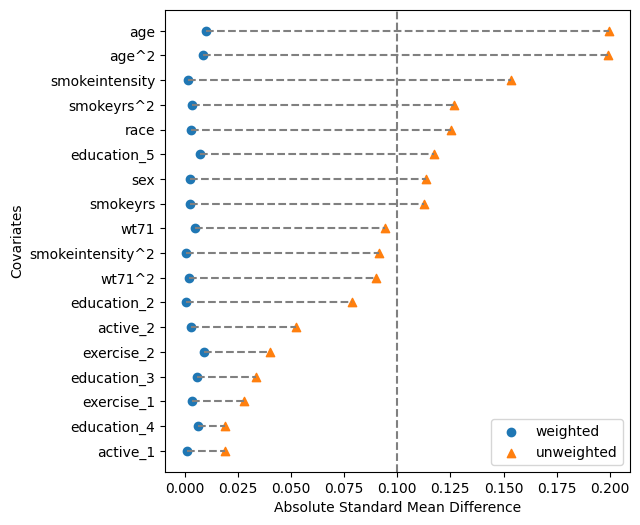

In [13]:
# IPW 推定量 ipw の妥当性をチェックするために、共変量バランスなどを評価する。
# evaluate は causallib のユーティリティで、与えられた推定器（ここでは IPW）について
#   - 処置群／対照群の共変量バランス（ASMD など）
#   - 重みの分布
#   - 推定された因果効果のサマリ
# などをまとめた評価オブジェクトを返す。
#
# 理論的には、「傾向スコアを使って重み付けした結果、本当に交絡が緩和されたか？」を
# 数値的・図的に確認するステップであり、
#   ・条件付き交換可能性を “X で条件付ければ十分” とみなしてよいか
#   ・IPW によって X の分布が処置群・対照群で揃っているか
# を検証するための重要な診断プロセスになる。
results = evaluate(ipw, data.X, data.a, data.y)

# 1 つの Figure と Axes を用意（Love プロットの描画先）
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# 共変量バランスの可視化（Love プロット）を描画する。
# kind="love" を指定すると、各共変量ごとに
#   ・重み付け前（Unadjusted）
#   ・重み付け後（IPW 適用後）
# の標準化平均差（ASMD: Absolute Standardized Mean Difference）を
# 水平バーとして表示する「Love プロット」が描かれる。
#
# ASMD は一般に、
#
#   $$ \text{ASMD}_j
#      = \frac{\bar{X}_{j, A=1} - \bar{X}_{j, A=0}}
#              {\sqrt{\frac{1}{2}(s_{j, A=1}^2 + s_{j, A=0}^2)}} $$
#
# のように定義され、処置群と対照群の平均差を標準偏差でスケーリングした指標である。
# 「0 に近いほど分布が似ている（= 交絡が小さい）」と解釈できる。
#
# 経験則としては、
#   |ASMD| < 0.1   → バランス良好
#   0.1〜0.2       → 注意が必要
#   > 0.2          → 深刻なバランス不良
# とみなされることが多い。
#
# thresh=0.1 は、この 0.1 を基準線（カットオフ）として Love プロット上に引かせる指定であり、
# 「IPW 適用後の ASMD がすべて 0.1 未満に収まっているか」を一目で確認するためのガイドになる。
# IPW が理論どおり機能していれば、重み付け後の点（バー）がこの閾値線より左側（0 に近い側）に
# 集中しているはずであり、それが「疑似ランダム化がうまくいっている」ことの視覚的エビデンスになる。
results.plot_covariate_balance(
    kind="love", ax=ax, thresh=0.1
)  # ASMD のカットオフ値(thresh)を 0.1 に設定

<Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

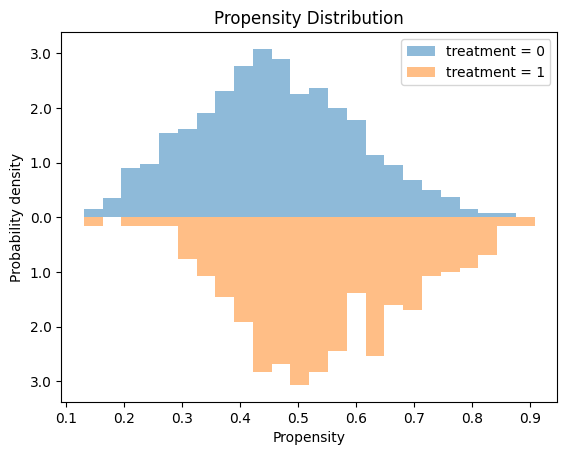

In [14]:
# ============================================================
# IPW における「重み分布」の診断
# ============================================================
# IPW（Inverse Probability Weighting）の理論では、
#   - 処置群:   w_i = 1 / e(X_i)
#   - 対照群:   w_i = 1 / (1 - e(X_i))
# のような「逆確率重み」を各サンプルに掛けることで、
# 共変量 X に依らず A がランダムに割り付けられた疑似母集団を作る。
#
# しかし実務的には、傾向スコア e(X_i) が 0 や 1 に近いサンプルがあると
#   - w_i が非常に大きくなる（極端な重み）
#   - 有効サンプルサイズが事実上小さくなり、分散が爆発する
#   - 少数の個体に推定結果が支配され、ロバストでなくなる
# といった問題が起きる。
#
# これは positivity（重複支持）の仮定
#
#   0 < P(A = 1 | X) < 1  （すべての X について）
#
# が現実には破れている（ある X ではほぼ必ず A=1 or A=0 になっている）
# ことの症状として現れる。
#
# results.plot_weight_distribution() は、
#   - IPW の重み w_i のヒストグラムや密度を描画することで、
#     「極端に大きい重み」が存在しないかどうかを視覚的に確認する
# ための診断ツールである。
#
# 典型的な読み方：
#   - 重みが 1 付近に集中していれば、重み付けは穏やかで分散も抑えやすい。
#   - 少数のサンプルにだけ非常に大きな重み（例：> 10, > 50）が付いていれば、
#     そのサンプルが推定をほぼ支配しており、ATE 推定量の分散やロバスト性に
#     深刻な問題がある可能性が高い。
#
# もし極端な重みが確認された場合の対策例：
#   - 重みのトリミング（w_i をある上限で切る）
#   - stabilized weights（分子に P(A=a_i) を入れて振れ幅を抑える）
#   - モデルの仕様変更（非線形項・交互作用を追加、別の learner を試す）
#   - positivity が根本的に破れている場合は、解析対象のサブポピュレーションを
#     限定する（Overlapping のある領域に絞る）ことも検討する。
#
# まとめると、この一行は
#   「IPW によって理論どおり ‘きれいな疑似実験’ を作れているか？」
# をバイアスだけでなく「分散・安定性」の観点からチェックする重要なステップである。
results.plot_weight_distribution()